In [58]:
import shutil
from experiment import Experiment
import matplotlib.pyplot as plt
import scheme_parameters

In [2]:
# Unzip files
# shutil.unpack_archive("data_export.zip", "data")

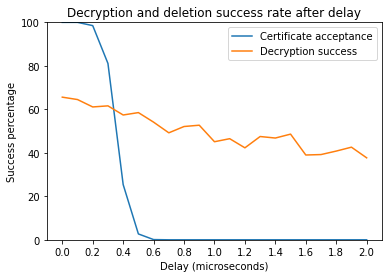

In [3]:
folder_prefix = "data/report/delay-oslo"
experiment_group_id = "delay"
number_of_experiments = 21
experiments = [Experiment.reconstruct_experiment_from_folder(f"{folder_prefix}/{experiment_group_id}-{i}", include_circuits=False) for i in range(number_of_experiments)]

x = [i*0.1 for i in range(21)]
certificate_acceptance = [exp.get_test1_success_rate() for exp in experiments]
decryption_success = [exp.get_test2_success_rate() for exp in experiments]

plt.title("Decryption and deletion success rate after delay")
plt.xlabel("Delay (microseconds)")
plt.ylabel("Success percentage")
plt.xticks([0.2 * i for i in range(11)])
plt.ylim(0, 100)
plt.plot(x, certificate_acceptance, label="Certificate acceptance")
plt.plot(x, decryption_success, label="Decryption success")
plt.legend()
plt.show()

In [4]:
from scipy.optimize import minimize, LinearConstraint, Bounds
from scipy.stats import binom
from math import floor, log, sqrt, e, comb
from typing import Tuple, cast
import scheme_parameters

def h(x):
    return (-x)*log(x, 2) - (1-x)*log(1-x, 2)

def equation_108(nu: float, params: scheme_parameters.SchemeParameters):
    """Returns the bound of Eq. 108 of [BI20], given a value for nu and a set of scheme parameters."""
    e_exp = (-params.s * (params.k**2) * (nu**2))/(params.m * (params.k + 1))
    sqrt_exp = -(params.s * (1 - h(params.delta + nu))) + params.n + params.tau + params.mu
    return 2 * ((0.5 * sqrt(2 ** sqrt_exp)) + 2 * (e**e_exp))

def optimize_for_params(params: scheme_parameters.SchemeParameters):
    """Returns the lowest value of Eq. 108, given a set of scheme parameters."""
    x0 = [0.002]
    bounds = [[0.0001, 0.5-params.delta]]
    res = minimize(equation_108, x0, args=params, bounds=bounds)
    return res.fun

In [5]:
def expected_success_for_rm_code(r: int, m: int, error_rate: float, params: scheme_parameters.SchemeParameters):
    block_length = 2 ** m
    distance = 2 ** (m - r)
    can_correct = floor(((distance-1)/2))
    correct_r_prime_prob = cast(float, binom.cdf(can_correct, block_length, error_rate))
    incorrect_but_priv_collision_prob = (1-correct_r_prime_prob)/(2**params.n)
    return correct_r_prime_prob + incorrect_but_priv_collision_prob

def expected_success_for_hamming_code(r: int, error_rate: float, params: scheme_parameters.SchemeParameters):
    block_length = 2**r - 1
    can_correct = 1
    num_blocks = params.s / block_length
    correct_r_prime_prob = cast(float, 1 - binom.cdf(block_length - 2, block_length, 1 - error_rate)) ** num_blocks
    incorrect_but_priv_collision_prob = (1-correct_r_prime_prob)/(2**params.n)
    return correct_r_prime_prob + incorrect_but_priv_collision_prob

def expected_success_for_certificate_acceptance(error_rate: float, params: scheme_parameters.SchemeParameters):
    # Accept if hamming distance between certificate and candidate certificate is strictly less than k*delta
    # If k*delta is an integer, then we accept up to (k*delta) - 1 errors
    # Otherwise, we accept up to floor(k*delta) errors
    maximum_weight = params.k * params.delta
    if float.is_integer(maximum_weight):
        errors_accepted = int(maximum_weight - 1)
    else:
        errors_accepted = floor(maximum_weight)
    return binom.cdf(errors_accepted, params.k, error_rate)

Security for RM(4,7) using 864 qubits: 0.8804417032498728
Security for Hamming(4) using 864 qubits: 0.9499299245627584


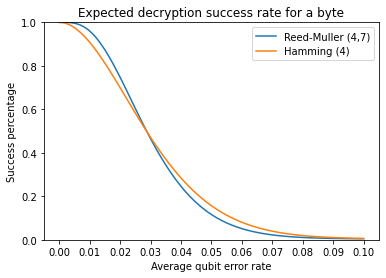

In [6]:
print(f"Security for RM(4,7) using {scheme_parameters.byte_rm_4_7.m} qubits: {optimize_for_params(scheme_parameters.byte_rm_4_7)}")
print(f"Security for Hamming(4) using {scheme_parameters.byte_hamming_4.m} qubits: {optimize_for_params(scheme_parameters.byte_hamming_4)}")

x = [i*0.001 for i in range(101)]
rm_success = [expected_success_for_rm_code(4, 7, x_i, scheme_parameters.byte_rm_4_7) for x_i in x]
hamming_success = [expected_success_for_hamming_code(4, x_i, scheme_parameters.byte_hamming_4) for x_i in x]

plt.title("Expected decryption success rate for a byte")
plt.xlabel("Average qubit error rate")
plt.ylabel("Success percentage")
plt.xticks([i*0.01 for i in range(11)])
plt.ylim(0, 1)
plt.plot(x, rm_success, label="Reed-Muller (4,7)")
plt.plot(x, hamming_success, label="Hamming (4)")
plt.legend()
plt.show()

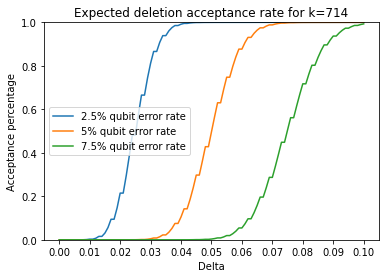

In [7]:
x = [i*0.001 for i in range(101)]
params = []
for x_i in x:
    params.append(scheme_parameters.SchemeParameters(
        security_parameter_lambda=1,
        n=8,
        k=714,
        s=150,
        tau=0,
        mu=40,
        delta=x_i,
        error_correcting_code_name="hamming_4",
    ))
success_025 = [expected_success_for_certificate_acceptance(0.025, params[i]) for i, x_i in enumerate(x)]
success_05 = [expected_success_for_certificate_acceptance(0.05, params[i]) for i, x_i in enumerate(x)]
success_075 = [expected_success_for_certificate_acceptance(0.075, params[i]) for i, x_i in enumerate(x)]

plt.title(f"Expected deletion acceptance rate for k={params[0].k}")
plt.xlabel("Delta")
plt.ylabel("Acceptance percentage")
plt.xticks([i*0.01 for i in range(11)])
plt.plot(x, success_025, label="2.5% qubit error rate")
plt.plot(x, success_05, label="5% qubit error rate")
plt.plot(x, success_075, label="7.5% qubit error rate")
plt.ylim(0, 1)
plt.legend()
plt.show()

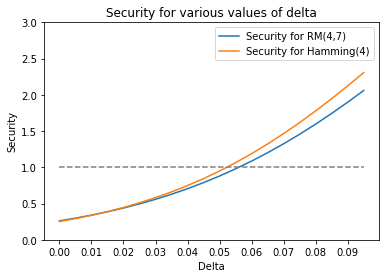

In [8]:
x = [i*0.005 for i in range(20)]
params_rm_4_7 = []
params_hamming_4 = []

for x_i in x:
    params_rm_4_7.append(scheme_parameters.SchemeParameters(
        security_parameter_lambda=1,
        n=8,
        k=736,
        s=128,
        tau=0,
        mu=29,
        delta=x_i,
        error_correcting_code_name="reed_muller_4_7"
    ))

    params_hamming_4.append(scheme_parameters.SchemeParameters(
        security_parameter_lambda=1,
        n=8,
        k=714,
        s=150,
        tau=0,
        mu=40,
        delta=x_i,
        error_correcting_code_name="hamming_4",
    ))
security_rm = [optimize_for_params(params_rm_4_7[i]) for i in range(len(x))]
security_hamming = [optimize_for_params(params_hamming_4[i]) for i in range(len(x))]

plt.title(f"Security for various values of delta")
plt.xlabel("Delta")
plt.ylabel("Security")
plt.xticks([i*0.01 for i in range(11)])
plt.plot(x, security_rm, label="Security for RM(4,7)")
plt.plot(x, security_hamming, label="Security for Hamming(4)")
plt.plot(x, [1 for _ in range(len(x))], linestyle="dashed", color="grey")
plt.ylim(0, 3)
plt.legend()
plt.show()

In [66]:
folder_prefix = "data/report/cmc4"
experiment_group_id = "cmc4"
number_of_experiments = 50
experiments = [Experiment.reconstruct_experiment_from_folder(f"{folder_prefix}/{experiment_group_id}-{i}", include_circuits=False) for i in range(number_of_experiments)]

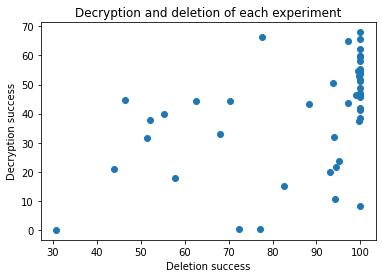

In [57]:
deletion_success = []
decryption_success = []
for exp in experiments:
    deletion_success.append(exp.get_test1_success_rate())
    decryption_success.append(exp.get_test2_success_rate())

plt.scatter(deletion_success, decryption_success)
plt.title("Decryption and deletion of each experiment")
plt.xlabel("Deletion success")
plt.ylabel("Decryption success")
plt.show()

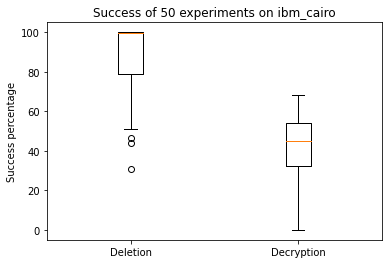

In [40]:
figure, axis = plt.subplots()
axis.set_title('Success of 50 experiments on ibm_cairo')
axis.boxplot([deletion_success, decryption_success])
axis.set_xticklabels(["Deletion", "Decryption"])
plt.ylabel("Success percentage")
plt.show()

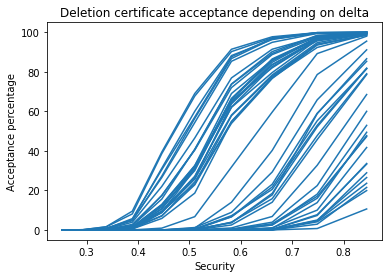

In [56]:
def get_success_rate_with_new_delta(exp: Experiment, new_delta: float) -> float:
    old_delta = exp.scheme_parameters.delta
    exp.scheme_parameters.delta = new_delta
    new_success_rate = exp.get_test1_success_rate()
    exp.scheme_parameters.delta = old_delta
    return new_success_rate

for exp in experiments:
    deltas = [0 + i*0.005 for i in range(10)]
    security = [
        optimize_for_params(scheme_parameters.SchemeParameters(
            security_parameter_lambda=exp.scheme_parameters.security_parameter_lambda,
            n=exp.scheme_parameters.n,
            k=exp.scheme_parameters.k,
            s=exp.scheme_parameters.s,
            tau=exp.scheme_parameters.tau,
            mu=exp.scheme_parameters.mu,
            delta=delta,
            error_correcting_code_name=exp.scheme_parameters.error_correcting_code_name
        ))
        for delta in deltas
    ]
    certificate_acceptance = [get_success_rate_with_new_delta(exp, delta) for delta in deltas]
    plt.plot(security, certificate_acceptance, color="#1f77b4")

plt.title("Deletion certificate acceptance depending on delta")
plt.xlabel("Security")
plt.ylabel("Acceptance percentage")
plt.show()

In [80]:
from utils import random_bit_matrix, random_bit_string, xor
from encryption_circuit import calculate_error_correction_hash
from states import Basis
import numpy as np

def get_stats_with_new_tau(exp: Experiment, new_tau: int) -> Tuple[int, int, int, int]:
    exp.scheme_parameters.tau = new_tau
    exp.key.error_correction_matrix = random_bit_matrix(exp.scheme_parameters.s, exp.scheme_parameters.tau)
    r_restricted_i = "".join(bit for i, bit in enumerate(exp.encoded_in_qubits) if exp.key.theta[i] is Basis.COMPUTATIONAL)
    exp.key.d = random_bit_string(exp.scheme_parameters.tau)
    exp.ciphertext.p = xor(calculate_error_correction_hash(exp.key.error_correction_matrix, r_restricted_i), exp.key.d)
    return exp.get_full_test2_reuslts()

correct_with_flag = []
correct_no_flag = []
incorrect_with_flag = []
incorrect_no_flag = []
exp = experiments[5]
for tau in range(10):
    c_w_f, c_n_f, i_w_f, i_n_f = get_stats_with_new_tau(exp, tau)
    correct_with_flag.append((c_w_f / exp.experiment_properties.shots) * 100)
    correct_no_flag.append((c_n_f / exp.experiment_properties.shots) * 100)
    incorrect_with_flag.append((i_w_f / exp.experiment_properties.shots) * 100)
    incorrect_no_flag.append((i_n_f / exp.experiment_properties.shots) * 100)

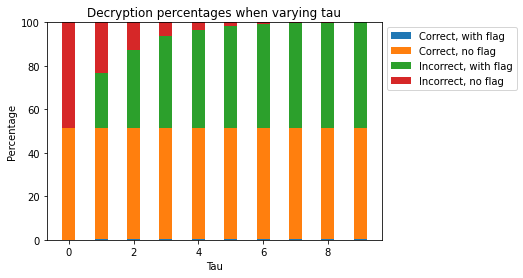

In [83]:
x = [i for i in range(10)]
width = 0.4

correct_with_flag = np.array(correct_with_flag)
correct_no_flag = np.array(correct_no_flag)
incorrect_with_flag = np.array(incorrect_with_flag)
incorrect_no_flag = np.array(incorrect_no_flag)

fig, ax = plt.subplots()

ax.bar(x, correct_with_flag, width, label='Correct, with flag')
ax.bar(x, correct_no_flag, width, bottom=correct_with_flag, label='Correct, no flag')
ax.bar(x, incorrect_with_flag, width, bottom=correct_with_flag+correct_no_flag, label='Incorrect, with flag')
ax.bar(x, incorrect_no_flag, width, bottom=correct_with_flag+correct_no_flag+incorrect_with_flag, label='Incorrect, no flag')  

ax.set_ylabel('Percentage')
ax.set_xlabel("Tau")
ax.set_title('Decryption percentages when varying tau')

plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()